In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)
inspector = inspect(engine)

In [10]:
columns = inspector.get_columns('Measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x116f7f080>,
 'tobs': 65.0,
 'prcp': 0.08,
 'station': 'USC00519397',
 'date': '2010-01-01',
 'id': 1}

In [12]:
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x116f7f9e8>,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'elevation': 3.0,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'longitude': -157.8168}

Exploratory Climate Analysis

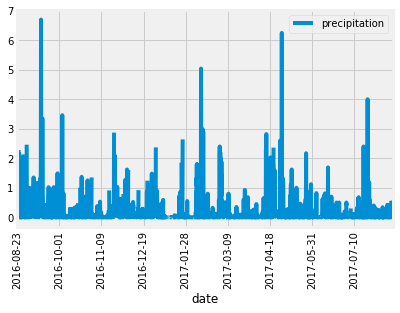

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)

precipitation = session.query(Measurement.date,Measurement.prcp).\
    filter((Measurement.date) >= query_date).all()

# Calculate the date 1 year ago from the last data point in the database
    
# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

df = pd.DataFrame(precipitation, columns=["date","precipitation"])
df.set_index(["date"],inplace = True)

# Sort the dataframe by date
df = df.sort_index()
df


# Use Pandas Plotting with Matplotlib to plot the data
df.plot(rot=90)

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data

df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [15]:
# Design a query to show how many stations are available in this dataset?

stations = session.query(Station.station).count()
print("There are {} stations".format(stations))

There are 9 stations


In [36]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, (func.count(Measurement.id))).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [86]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(
    (func.min(Measurement.tobs)),
    (func.max(Measurement.tobs)),
    (func.avg(Measurement.tobs))).\
    filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

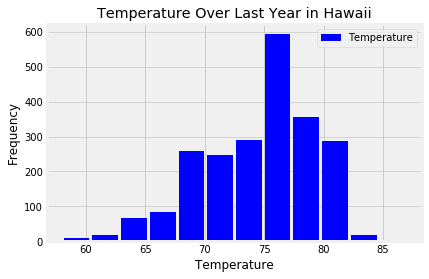

In [84]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
session.query(Measurement.station, (func.count(Measurement.tobs))).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc()).first()

query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)

Temp_last_year = session.query(Measurement.date,Measurement.tobs).\
    filter((Measurement.date) >= query_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
Temps_df = pd.DataFrame(Temp_last_year, columns=["date","Temperature"])

# plot the results as a histogram
Temps_df.plot.hist(grid=True, bins=12, rwidth=0.9,
                   color='blue')
plt.title('Temperature Over Last Year in Hawaii')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

# Temperature Analysis I